In [1]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,Input
from sklearn.utils import shuffle


import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import os
import pandas as pd
DATASET_ENCODING = "ISO-8859-1"

In [2]:
from google.colab import drive
drive.mount("/content/gdrive",  force_remount=True)

Mounted at /content/gdrive


In [3]:
#training.1600000.processed.noemoticon.csv
df = pd.read_csv('/content/gdrive/My Drive/Mestrado/training.1600000.processed.noemoticon.csv', \
                 names=['target', 'ids', 'date', 'flag', 'user', 'text'],\
                 encoding = 'latin-1', header=None)

In [4]:
df.groupby('target').count()

,ids,date,flag,user,text
target,,,,,
0,800000,800000,800000,800000,800000
4,800000,800000,800000,800000,800000


In [5]:
quantity = 2500
df = pd.concat([df.query("target==0").sample(quantity),df.query("target==4").sample(quantity)])
df.target = df.target.map({0:0,4:1})


In [6]:
import nltk
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import GridSearchCV
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer


In [7]:
# check the number of positive vs. negative tagged sentences
positives = df['target'][df.target == 0] # 0 is negative
negatives = df['target'][df.target == 1] # 4 is positive
print('number of positve tagged sentences is:  {}'.format(len(positives)))
print('number of negative tagged sentences is: {}'.format(len(negatives)))
print('total length of the data is:            {}'.format(df.shape[0]))

number of positve tagged sentences is:  2500
number of negative tagged sentences is: 2500
total length of the data is:            5000


In [8]:
# get a word count per sentence column
def word_count(sentence):
    return len(sentence.split())
    
df['word count'] = df['text'].apply(word_count)
df.head()

,target,ids,date,flag,user,text,word count
180923,0,1966677162,Fri May 29 18:11:50 PDT 2009,NO_QUERY,mrszjbarbar,@xXx_MzBuqz_xXx lmaoo I know I knowww..my dad ...,20
466040,0,2175479240,Mon Jun 15 01:06:05 PDT 2009,NO_QUERY,kaiilaaa,hit the microphone onto my lip while playing s...,27
511515,0,2189917691,Tue Jun 16 01:15:21 PDT 2009,NO_QUERY,scarlett_v,geography assignment well.... at least the ta...,9
731943,0,2263954795,Sun Jun 21 02:19:07 PDT 2009,NO_QUERY,m_hardwick,"Stupid cold, with your sneezing and sore throa...",14
467262,0,2175740986,Mon Jun 15 01:51:42 PDT 2009,NO_QUERY,dniz87,I feel good now. I think I'm moving on. And ge...,13


In [9]:
df['word count'].mean()

13.1756

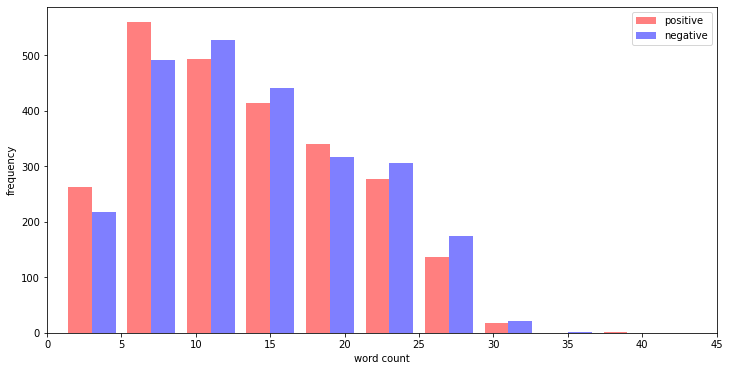

In [10]:
# plot word count distribution for both positive and negative sentiments
x = df['word count'][df.target == 1]
y = df['word count'][df.target == 0]
plt.figure(figsize=(12,6))
plt.xlim(0,45)
plt.xlabel('word count')
plt.ylabel('frequency')
g = plt.hist([x, y], color=['r','b'], alpha=0.5, label=['positive','negative'])
plt.legend(loc='upper right')

In [11]:
# get most common words in training dataset
from collections import Counter
all_words = []
for line in list(df['text']):
    words = line.split()
    for word in words:
        all_words.append(word.lower())
    
    
Counter(all_words).most_common(10)

[('i', 2398),
 ('to', 1767),
 ('the', 1568),
 ('a', 1203),
 ('my', 973),
 ('and', 927),
 ('you', 783),
 ('in', 678),
 ('is', 668),
 ('for', 623)]

In [12]:
import re
from string import punctuation
# helper function to clean tweets
def processTweet(tweet):
    # Remove HTML special entities (e.g. &amp;)
    tweet = re.sub(r'\&\w*;', '', tweet)
    #Convert @username to AT_USER
    tweet = re.sub('@[^\s]+','',tweet)
    # Remove tickers
    tweet = re.sub(r'\$\w*', '', tweet)
    # To lowercase
    tweet = tweet.lower()
    # Remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*\/\w*', '', tweet)
    # Remove hashtags
    tweet = re.sub(r'#\w*', '', tweet)
    # Remove Punctuation and split 's, 't, 've with a space for filter
    tweet = re.sub(r'[' + punctuation.replace('@', '') + ']+', ' ', tweet)
    # Remove words with 2 or fewer letters
    tweet = re.sub(r'\b\w{1,2}\b', '', tweet)
    # Remove whitespace (including new line characters)
    tweet = re.sub(r'\s\s+', ' ', tweet)
    # Remove single space remaining at the front of the tweet.
    tweet = tweet.lstrip(' ') 
    # Remove characters beyond Basic Multilingual Plane (BMP) of Unicode:
    tweet = ''.join(c for c in tweet if c <= '\uFFFF') 
    return tweet

In [13]:
df['text'] = df['text'].apply(processTweet)
# preview some cleaned tweets
df['text'].head()

180923    lmaoo know knowww dad still didn call yet lol ...
466040    hit the microphone onto lip while playing sing...
511515      geography assignment well least the tape funny 
731943    stupid cold with your sneezing and sore throat...
467262    feel good now think moving and getting sick ag...
Name: text, dtype: object

In [14]:
# tokenize helper function
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))


def remove_words(word_list):
    return [w for w in word_list if w not in stop_words]
    
def text_process(raw_text):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in list(raw_text) if char not in string.punctuation]
    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return ' '.join(remove_words([word for word in nopunc.lower().split() if word.lower() not in stopwords.words('english')]))




[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [15]:
df['text'] = df['text'].apply(lambda x : text_process(x))

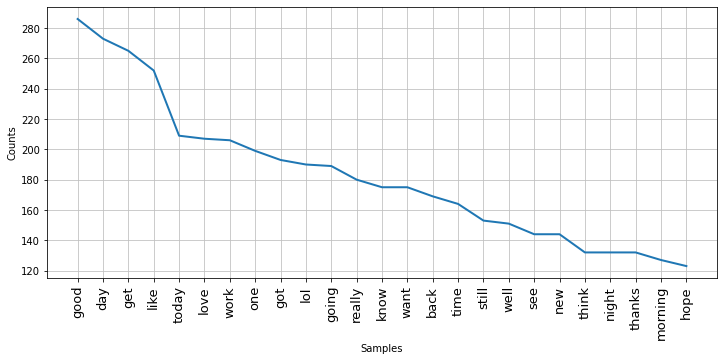

Text(0.5, 0, 'Word Rank')

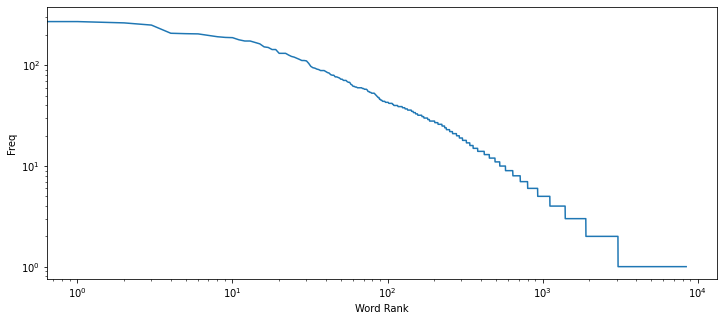

In [16]:
# most common words in twitter dataset
all_words = []
for line in list(df['text']):
    words = line.split()
    for word in words:
        all_words.append(word.lower())
# plot word frequency distribution of first few words
plt.figure(figsize=(12,5))
plt.xticks(fontsize=13, rotation=90)
fd = nltk.FreqDist(all_words)
fd.plot(25,cumulative=False)
# log-log of all words 
word_counts = sorted(Counter(all_words).values(), reverse=True)
plt.figure(figsize=(12,5))
plt.loglog(word_counts, linestyle='-', linewidth=1.5)
plt.ylabel("Freq")
plt.xlabel("Word Rank")

In [17]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


X_train, X_test, y_train, y_test = train_test_split(df['text'], df['target'], test_size=0.2)

classifiers = [
  {'classifier' : MultinomialNB(),
   'parameters' : {'bow__ngram_range': [(1, 1), (1, 2)],
                  'tfidf__use_idf': (True, False),
                  'classifier__alpha': (1e-2, 1e-3),}
   },
   {'classifier': DecisionTreeClassifier(), 
    'parameters': {'bow__ngram_range': [(1, 1), (1, 2)],
                  'tfidf__use_idf': (True, False),
                  'classifier__criterion': ['gini', 'entropy'],
                   'classifier__splitter': [ 'best'],
                   'classifier__class_weight': ['balanced']               
                   }
    },
   {'classifier': GaussianNB(),
    'parameters': {'bow__ngram_range': [(1, 1), (1, 2)],
                  'tfidf__use_idf': (True, False),
                   'classifier__var_smoothing': [1e-9, 1e-8, 1e-10]
                   }
    },
   {'classifier' : KNeighborsClassifier(),
    'parameters':{ 'bow__ngram_range': [(1, 1), (1, 2)],
                  'tfidf__use_idf': (True, False),
                  'classifier__n_neighbors': [3, 5],
                  'classifier__weights': [ 'distance'], # uniform
                    'classifier__p': [1,2]
                   }
    },
   {'classifier': LinearSVC(max_iter=1000000),
    'parameters': {
        'bow__ngram_range': [(1, 1), (1, 2)],
        'tfidf__use_idf': (True, False),
        'classifier__penalty': [ 'l2'],
        'classifier__loss': ['hinge', 'squared_hinge'],
        'classifier__C': [1.0, 10 ,100, 1000],
        'classifier__class_weight': [ 'balanced']               

    }
    },
   {'classifier': LogisticRegression(max_iter=1000000), 
     'parameters': {
        'bow__ngram_range': [(1, 1), (1, 2)],
        'tfidf__use_idf': (True, False),
        'classifier__penalty': ['l1', 'l2',], # supported by liblineaer
        'classifier__C': [1.0, 10 ,100, 1000],
        'classifier__class_weight': ['balanced'],
        'classifier__solver': ['liblinear'] # recommended for small datasets         
     }
    },
   {'classifier': RandomForestClassifier(),
     'parameters': {
        'bow__ngram_range': [(1, 1), (1, 2)],
        'tfidf__use_idf': (True, False),
        'classifier__n_estimators': [50, 100, 150, 200],
        'classifier__criterion': ['gini', 'entropy'],
        'classifier__class_weight': ['balanced', 'balanced_subsample' ]
     }
    }  

]


In [18]:
df['text'].shape

(5000,)

In [19]:
from sklearn.base import BaseEstimator, TransformerMixin

class DenseTransformer(TransformerMixin):

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return np.asarray(X.todense())

In [20]:
classifiers[4:5]

[{'classifier': LinearSVC(max_iter=1000000),
  'parameters': {'bow__ngram_range': [(1, 1), (1, 2)],
   'classifier__C': [1.0, 10, 100, 1000],
   'classifier__class_weight': ['balanced'],
   'classifier__loss': ['hinge', 'squared_hinge'],
   'classifier__penalty': ['l2'],
   'tfidf__use_idf': (True, False)}}]

In [21]:
# Run Train Data Through Pipeline analyzer=text_process
# uncomment below to train on a larger dataset but it's very slow for a slower machine.
# X_train, X_test, y_train, y_test = train_test_split(data['text'], data['label'], test_size=0.2)
#X_train, X_test, y_train, y_test = train_test_split(df['text'], df['target'], test_size=0.2, random_state=42)
from sklearn.preprocessing import MinMaxScaler
# 0-1
# 1-2 (demora)
# 2-3
# 3-4 (nao consegui acabar)
# 4-5 svm
# 5 - 6 (nao acablou)
# 6-7 (nao acabou)
for configuration in classifiers[0:1]:

  # create pipeline
  pipeline = Pipeline([
      ('bow', CountVectorizer(strip_accents='ascii',
                              stop_words='english',
                              lowercase=True)),  # strings to token integer counts
      ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
      ('to_dense', DenseTransformer()),
      #('scaling', MinMaxScaler()),
      ('classifier', configuration['classifier']),  # train on TF-IDF vectors w/ Naive Bayes classifier
  ])

  # do 10-fold cross validation for each of the 6 possible combinations of the above params
  grid = GridSearchCV(pipeline, cv=5, param_grid=configuration['parameters'], verbose=1)
  grid.fit(X_train,y_train)
  # summarize results
  print("\nBest Model: %f using %s" % (grid.best_score_, grid.best_params_))
  print('\n')
  means = grid.cv_results_['mean_test_score']
  stds = grid.cv_results_['std_test_score']
  params = grid.cv_results_['params']
  for mean, stdev, param in zip(means, stds, params):
      print("Mean: %f Stdev:(%f) with: %r" % (mean, stdev, param))
  #joblib.dump(grid, "twitter_sentiment.pkl")
  # load from file and predict using the best configs found in the CV step
  #model_NB = joblib.load("twitter_sentiment.pkl" )
  # get predictions from best model above
  y_preds = grid.predict(X_test)
  print('accuracy score: ',accuracy_score(y_test, y_preds))
  print('\n')
  print('confusion matrix: \n',confusion_matrix(y_test,y_preds))
  print('\n')
  print(classification_report(y_test, y_preds))

  

Fitting 5 folds for each of 8 candidates, totalling 40 fits

Best Model: 0.673750 using {'bow__ngram_range': (1, 1), 'classifier__alpha': 0.01, 'tfidf__use_idf': False}


Mean: 0.663500 Stdev:(0.014085) with: {'bow__ngram_range': (1, 1), 'classifier__alpha': 0.01, 'tfidf__use_idf': True}
Mean: 0.673750 Stdev:(0.009906) with: {'bow__ngram_range': (1, 1), 'classifier__alpha': 0.01, 'tfidf__use_idf': False}
Mean: 0.658750 Stdev:(0.013987) with: {'bow__ngram_range': (1, 1), 'classifier__alpha': 0.001, 'tfidf__use_idf': True}
Mean: 0.668000 Stdev:(0.010886) with: {'bow__ngram_range': (1, 1), 'classifier__alpha': 0.001, 'tfidf__use_idf': False}
Mean: 0.655500 Stdev:(0.016875) with: {'bow__ngram_range': (1, 2), 'classifier__alpha': 0.01, 'tfidf__use_idf': True}
Mean: 0.667250 Stdev:(0.015480) with: {'bow__ngram_range': (1, 2), 'classifier__alpha': 0.01, 'tfidf__use_idf': False}
Mean: 0.651750 Stdev:(0.016058) with: {'bow__ngram_range': (1, 2), 'classifier__alpha': 0.001, 'tfidf__use_idf': Tru

In [22]:
df_validation = pd.read_csv('/content/gdrive/My Drive/Mestrado/sentiment_dataset.csv')

df_validation =df_validation[df_validation['sentiment']!='neutral']
### add my dataset and check it
df_validation_positive = df_validation[ df_validation['sentiment'] == 'positive']
df_validation_negative = df_validation[ df_validation['sentiment'] == 'negative']
df_validation = pd.concat([df_validation_positive,df_validation_negative])
df_validation['sentiment'] =df_validation['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

In [23]:
df_validation

,Unnamed: 0,text,sentiment
10,10,"Hi allThanks for ur replies , my son is 25 mon...",1
14,14,I wanted to circle back around and see how it ...,1
32,32,"Hi. Well, that's great you used a condom. Pu...",1
46,46,"Hi callalily,I haven't had Omicron, but got th...",1
61,61,I just watched an episode of Mystery Diagnosis...,1
...,...,...,...
480,195,"I have been experiencing similar issues, I hav...",0
481,196,This is the first time that I have heard anyon...,0
483,198,Thank you for posting. I saw starting to think...,0
485,200,I have been doing his for years. especially at...,0


In [24]:
y_test1 = df_validation['sentiment']
y_preds1 = grid.predict(df_validation['text'])
print('accuracy score: ',accuracy_score(y_test1, y_preds1))
print('\n')
print('confusion matrix: \n',confusion_matrix(y_test1,y_preds1))
print('\n')
print(classification_report(y_test1, y_preds1))

accuracy score:  0.7258883248730964


confusion matrix: 
 [[113  29]
 [ 25  30]]


              precision    recall  f1-score   support

           0       0.82      0.80      0.81       142
           1       0.51      0.55      0.53        55

    accuracy                           0.73       197
   macro avg       0.66      0.67      0.67       197
weighted avg       0.73      0.73      0.73       197



# Neural network based

In [25]:
#training.1600000.processed.noemoticon.csv
import pandas as pd
df = pd.read_csv('/content/gdrive/My Drive/Mestrado/training.1600000.processed.noemoticon.csv', \
                 names=['target', 'ids', 'date', 'flag', 'user', 'text'],\
                 encoding = 'latin-1', header=None)

In [26]:
quantity = 100000
r = 42
df = pd.concat([df.query("target==0").sample(quantity, random_state = r),df.query("target==4").sample(quantity, random_state = r)])
df.target = df.target.map({0:0,4:1})

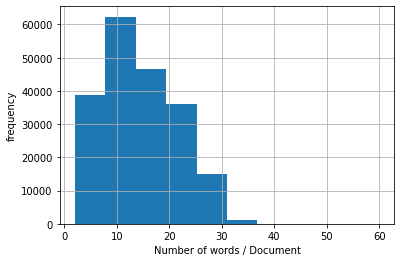

In [63]:
df['text'].apply(lambda x : len(x.split(' '))).hist()
plt.xlabel('Number of words / Document')
plt.ylabel('frequency')
plt.show()

In [28]:
df.shape, df.head()

((200000, 6),
         target         ids                          date      flag  \
 212188       0  1974671194  Sat May 30 13:36:31 PDT 2009  NO_QUERY   
 299036       0  1997882236  Mon Jun 01 17:37:11 PDT 2009  NO_QUERY   
 475978       0  2177756662  Mon Jun 15 06:39:05 PDT 2009  NO_QUERY   
 588988       0  2216838047  Wed Jun 17 20:02:12 PDT 2009  NO_QUERY   
 138859       0  1880666283  Fri May 22 02:03:31 PDT 2009  NO_QUERY   
 
                   user                                               text  
 212188         simba98  @xnausikaax oh no! where did u order from? tha...  
 299036          Seve76  A great hard training weekend is over.  a coup...  
 475978  x__claireyy__x  Right, off to work  Only 5 hours to go until I...  
 588988          Balasi                    I am craving for japanese food   
 138859    djrickdawson  Jean Michel Jarre concert tomorrow  gotta work...  )

In [29]:
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [30]:
def vectorize(df):
    embeded_tweets = embed(df['text'].values.tolist()).numpy()
    targets = df.target.values
    return embeded_tweets,targets

embeded_tweets,targets = vectorize(df)


In [31]:
embeded_tweets.shape

(200000, 512)

In [32]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Input
from tensorflow.keras.optimizers import SGD


In [33]:
def create_model():
  model = Sequential()
  model.add(Input(shape=(512,),dtype='float32'))
  model.add(Dropout(0.3))
  model.add(Dense(64, activation = 'relu'))
  model.add(Dropout(0.3))
  model.add(Dense(64, activation = 'relu'))
  model.add(Dropout(0.3))
  model.add(Dense(64, activation = 'relu'))
  model.add(Dense(1, activation = 'sigmoid'))
  model.compile(loss='binary_crossentropy', 
                optimizer='adam',
                metrics=['acc'])
  return model

In [34]:
model  = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 64)                32832     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 1)                 6

In [35]:
num_epochs = 10
batch_size = 64   ## 2^x

history = model.fit(embeded_tweets, 
                    targets, 
                    epochs=num_epochs, 
                    validation_split=0.1, 
                    shuffle=True,
                    batch_size=batch_size)

Epoch 1/10
2813/2813 [==============================] - 11s 3ms/step - loss: 0.4865 - acc: 0.7660 - val_loss: 0.4937 - val_acc: 0.7566
Epoch 2/10
2813/2813 [==============================] - 10s 4ms/step - loss: 0.4661 - acc: 0.7787 - val_loss: 0.4766 - val_acc: 0.7528
Epoch 3/10
2813/2813 [==============================] - 11s 4ms/step - loss: 0.4595 - acc: 0.7828 - val_loss: 0.5037 - val_acc: 0.7508
Epoch 4/10
2813/2813 [==============================] - 17s 6ms/step - loss: 0.4553 - acc: 0.7853 - val_loss: 0.4747 - val_acc: 0.7808
Epoch 5/10
2813/2813 [==============================] - 15s 5ms/step - loss: 0.4532 - acc: 0.7874 - val_loss: 0.5577 - val_acc: 0.7351
Epoch 6/10
2813/2813 [==============================] - 9s 3ms/step - loss: 0.4498 - acc: 0.7896 - val_loss: 0.4874 - val_acc: 0.7642
Epoch 7/10
2813/2813 [==============================] - 9s 3ms/step - loss: 0.4483 - acc: 0.7894 - val_loss: 0.4828 - val_acc: 0.7611
Epoch 8/10
2813/2813 [==============================] - 1

In [36]:
#df_validation.sentiment = df_validation.sentiment.map({0:0,4:1})


In [37]:
df_validation = pd.read_csv('/content/gdrive/My Drive/Mestrado/sentiment_dataset.csv')

df_validation =df_validation[df_validation['sentiment']!='neutral']
### add my dataset and check it
df_validation_positive = df_validation[ df_validation['sentiment'] == 'positive']
df_validation_negative = df_validation[ df_validation['sentiment'] == 'negative']
df_validation = pd.concat([df_validation_positive,df_validation_negative])
df_validation['sentiment'] =df_validation['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

In [38]:
y_preds1 = model.predict(embed(df_validation['text'].values.tolist()).numpy())

In [39]:
y_preds1 = (y_preds1 > 0.5)

In [40]:
y_test1 = df_validation['sentiment']


In [41]:
len(y_test1), len(y_preds1)

(197, 197)

In [42]:
#y_test1 = df_validation['sentiment']
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
print('accuracy score: ',accuracy_score(y_test1, y_preds1))
print('\n')
print('confusion matrix: \n',confusion_matrix(y_test1,y_preds1))
print('\n')
print(classification_report(y_test1, y_preds1))

accuracy score:  0.868020304568528


confusion matrix: 
 [[134   8]
 [ 18  37]]


              precision    recall  f1-score   support

           0       0.88      0.94      0.91       142
           1       0.82      0.67      0.74        55

    accuracy                           0.87       197
   macro avg       0.85      0.81      0.83       197
weighted avg       0.87      0.87      0.86       197



In [43]:
y_test1 = y_test1.tolist()


In [44]:
wrong = [i for i,v in enumerate(y_preds1) if y_preds1[i]!=y_test1[i]]

import numpy as np
correct = set(np.arange(len(y_test1))) - set(wrong)

In [45]:
#df_validation.reset_index(inplace=True)

In [46]:
X = embed(df_validation['text'].values.tolist()).numpy()
y=  np.array(df_validation['sentiment'].tolist())

In [47]:
X1 = X[list(correct)]
y1 = y[list(correct)]

In [48]:
X1.shape, y1.shape

((171, 512), (171,))

In [49]:
from sklearn.model_selection import train_test_split

#X_train = X[list(training)]
#X_test = X[list(testing)]
#y_train = y[list(training)]
#y_test = y[list(testing)]

X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.2, random_state=42, \
                                                  stratify = y1, shuffle=True)

In [50]:
splitter = int(len(wrong)/2)

In [51]:
X_train = np.concatenate((X_train,  X[wrong[0: splitter]]))
y_train = np.concatenate((y_train,  y[wrong[0: splitter]]))

In [52]:
y_test.shape, y[wrong[0:3]].shape

((35,), (3,))

In [53]:
X_test = np.concatenate((X_test,  X[wrong[splitter:]]))
y_test = np.concatenate((y_test,  y[wrong[splitter:]]))

In [54]:
y_preds1 = model.predict(X_test)
y_preds1 = (y_preds1 > 0.5)

In [55]:
#y_test1 = df_validation['sentiment']
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
print('accuracy score: ',accuracy_score(y_test, y_preds1))
print('\n')
print('confusion matrix: \n',confusion_matrix(y_test,y_preds1))
print('\n')
print(classification_report(y_test, y_preds1))

accuracy score:  0.7291666666666666


confusion matrix: 
 [[27  8]
 [ 5  8]]


              precision    recall  f1-score   support

           0       0.84      0.77      0.81        35
           1       0.50      0.62      0.55        13

    accuracy                           0.73        48
   macro avg       0.67      0.69      0.68        48
weighted avg       0.75      0.73      0.74        48



In [56]:
'''
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
# Instantiate the cross validator
skf = StratifiedKFold(n_splits=5, shuffle=True)


accuracy = []
precision = []
recall = []
f1_scores = []

for train_index, test_index in skf.split(X, y):
    print("TRAIN:", train_index.shape, "TEST:", test_index.shape)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model = create_model()

    history = model.fit(embeded_tweets, 
                    targets, 
                    epochs=num_epochs, 
                    validation_split=0.1, 
                    shuffle=True,
                    batch_size=batch_size)

    history = model.fit(X_train, 
                    y_train, 
                    epochs=num_epochs, 
                    #validation_split=0.1, 
                    shuffle=True,
                    batch_size=batch_size)
    
    y_preds1 = model.predict(X_test)
    y_preds1 = (y_preds1 > 0.5)

    accuracy.append(accuracy_score(y_test, y_preds1))
    precision.append(precision_score(y_test, y_preds1))
    recall.append(recall_score(y_test, y_preds1))
    f1_scores.append(f1_scores(y_test, y_preds1))

    #y_test1 = df_validation['sentiment']
    from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
    print('accuracy score: ',accuracy_score(y_test, y_preds1))
    print('\n')
    print('confusion matrix: \n',confusion_matrix(y_test,y_preds1))
    print('\n')
    print(classification_report(y_test, y_preds1))

'''

'\nfrom sklearn.model_selection import StratifiedKFold\nfrom sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score\n# Instantiate the cross validator\nskf = StratifiedKFold(n_splits=5, shuffle=True)\n\n\naccuracy = []\nprecision = []\nrecall = []\nf1_scores = []\n\nfor train_index, test_index in skf.split(X, y):\n    print("TRAIN:", train_index.shape, "TEST:", test_index.shape)\n    X_train, X_test = X[train_index], X[test_index]\n    y_train, y_test = y[train_index], y[test_index]\n\n    model = create_model()\n\n    history = model.fit(embeded_tweets, \n                    targets, \n                    epochs=num_epochs, \n                    validation_split=0.1, \n                    shuffle=True,\n                    batch_size=batch_size)\n\n    history = model.fit(X_train, \n                    y_train, \n                    epochs=num_epochs, \n                    #validation_split=0.1, \n                    shuffle=True,\n                    batch_siz

In [57]:
from sklearn.utils import class_weight


class_weights = class_weight.compute_class_weight('balanced', classes= np.unique(y_train), y = y_train)
class_weights = dict(zip(np.unique(y_train), class_weights ))
class_weights

{0: 0.6962616822429907, 1: 1.7738095238095237}

In [58]:
num_epochs = 10
batch_size = 1   ## 2^x

history = model.fit(X_train, 
                    y_train, 
                    epochs=num_epochs, 
                    #validation_split=0.1, 
                    shuffle=True,
                    batch_size=batch_size, class_weight=class_weights) 

Epoch 1/10
149/149 [==============================] - 1s 3ms/step - loss: 0.3934 - acc: 0.8523
Epoch 2/10
149/149 [==============================] - 0s 3ms/step - loss: 0.3446 - acc: 0.9128
Epoch 3/10
149/149 [==============================] - 0s 3ms/step - loss: 0.2254 - acc: 0.9396
Epoch 4/10
149/149 [==============================] - 0s 3ms/step - loss: 0.1758 - acc: 0.9463
Epoch 5/10
149/149 [==============================] - 0s 3ms/step - loss: 0.1070 - acc: 0.9799
Epoch 6/10
149/149 [==============================] - 0s 3ms/step - loss: 0.0992 - acc: 0.9799
Epoch 7/10
149/149 [==============================] - 0s 3ms/step - loss: 0.1453 - acc: 0.9664
Epoch 8/10
149/149 [==============================] - 0s 3ms/step - loss: 0.0855 - acc: 0.9732
Epoch 9/10
149/149 [==============================] - 0s 3ms/step - loss: 0.0433 - acc: 0.9933
Epoch 10/10
149/149 [==============================] - 0s 3ms/step - loss: 0.1161 - acc: 0.9597


In [59]:
y_preds1 = model.predict(X_test)

In [60]:
y_preds1 = (y_preds1 > 0.5)

In [61]:
#y_test1 = df_validation['sentiment']
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
print('accuracy score: ',accuracy_score(y_test, y_preds1))
print('\n')
print('confusion matrix: \n',confusion_matrix(y_test,y_preds1))
print('\n')
print(classification_report(y_test, y_preds1))

accuracy score:  0.7916666666666666


confusion matrix: 
 [[26  9]
 [ 1 12]]


              precision    recall  f1-score   support

           0       0.96      0.74      0.84        35
           1       0.57      0.92      0.71        13

    accuracy                           0.79        48
   macro avg       0.77      0.83      0.77        48
weighted avg       0.86      0.79      0.80        48



# universal sentnece encoders foram introduzidos em https://arxiv.org/pdf/1803.11175v2.pdf
imp: The encoders used in such models require modelling the meaning of word sequences instead of individual words. Apart from single words, the models are trained and optimized for text having more-than-word lengths such as sentences, phrases or paragraphs. 